In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 8.9 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

# Define a ticker and a date range for your data
ticker = 'SPY'  # S&P 500 ETF, a good proxy for the market
start_date = '2010-01-01'
end_date = '2025-07-31'

# Download historical data from Yahoo Finance
# We will explicitly use auto_adjust=True to get the adjusted closing prices.
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

display(data)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.515617,85.560890,84.142297,84.791229,118944600
2010-01-05,85.742004,85.779735,85.153439,85.462816,111579900
2010-01-06,85.802383,86.013663,85.591104,85.659013,116074400
2010-01-07,86.164566,86.270206,85.402447,85.643910,131091100
2010-01-08,86.451309,86.489040,85.764652,85.938200,126402800
...,...,...,...,...,...
2025-07-24,634.419983,636.150024,633.989990,634.599976,71307100
2025-07-25,637.099976,637.580017,634.840027,635.090027,56865400


Data for SPY from 2010-01-01 to 2025-07-31
--------------------------------------------------
Ticker          SPY
count   3916.000000
mean       0.051177
std        1.094580
min      -11.588676
25%       -0.371771
50%        0.069405
75%        0.578578
max        9.986286
--------------------------------------------------


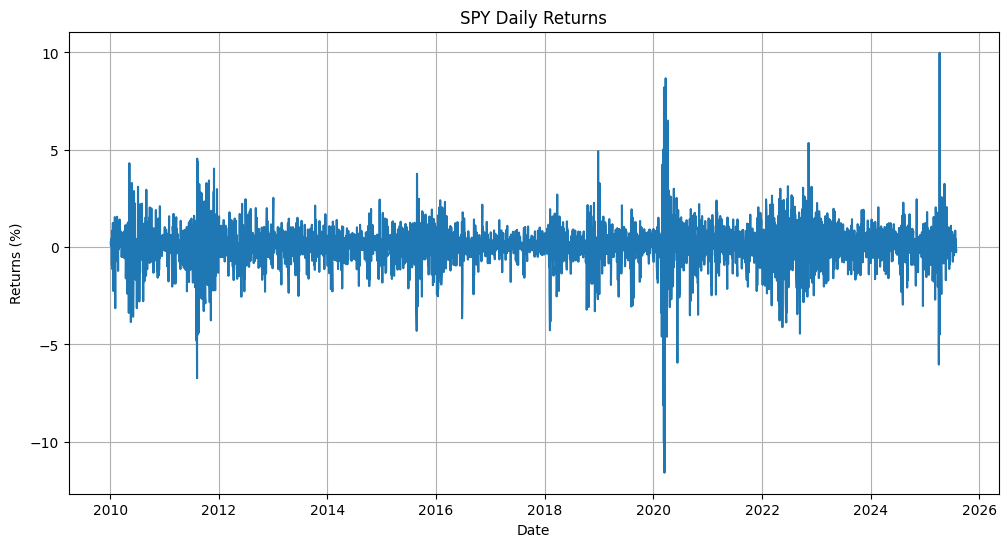

In [3]:
# Calculate logarithmic returns
# GARCH models are typically applied to returns, not raw prices.
# Log returns are often preferred as they are time-additive and more symmetric.
# Calculate logarithmic returns
returns = 100 * np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Print a summary of the data
print(f"Data for {ticker} from {start_date} to {end_date}")
print("-" * 50)
print(returns.describe())
print("-" * 50)

# Optional: Plot the returns to visualize volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(returns)
plt.title(f'{ticker} Daily Returns')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# The 'returns' Series is now ready to be used in the next cell for GARCH modeling.

In [4]:
# Assuming your 'returns' series is from the previous step
# Define a split date for your training and testing sets
split_date = '2024-07-31'  # Example: use the last year for testing

# Split the data
train_returns = returns[returns.index <= split_date]
test_returns = returns[returns.index > split_date]

print(f"Training data size: {len(train_returns)} observations")
print(f"Testing data size: {len(test_returns)} observations")

Training data size: 3667 observations
Testing data size: 249 observations


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4680.50
Distribution:                  Normal   AIC:                           9369.00
Method:            Maximum Likelihood   BIC:                           9393.83
                                        No. Observations:                 3667
Date:                Fri, Aug 01 2025   Df Residuals:                     3666
Time:                        21:11:19   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0870  1.230e-02      7.069  1.556e-12 [6.286e-0

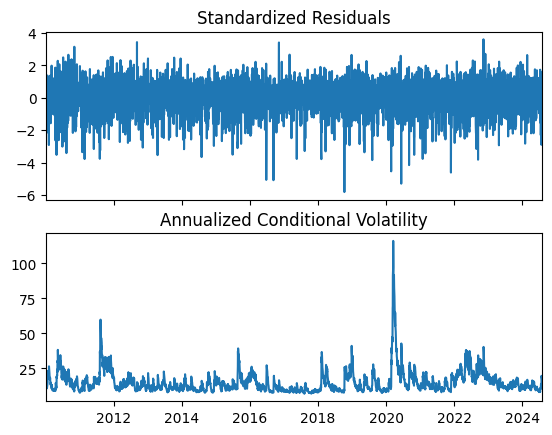

In [5]:
# Create a GARCH model
# This uses a standard GARCH(1,1) model with a constant mean.
# 'p' is the order of the ARCH term (past squared residuals).
# 'q' is the order of the GARCH term (past conditional variances).
# Fit the GARCH(1,1) model on the training data
am_train = arch_model(train_returns, vol='Garch', p=1, q=1, mean='Constant')
res_train = am_train.fit(disp='off')

# Print the summary of the trained model to see its coefficients
print(res_train.summary())

# Plot the conditional volatility from the model
fig = res_train.plot(annualize='D')

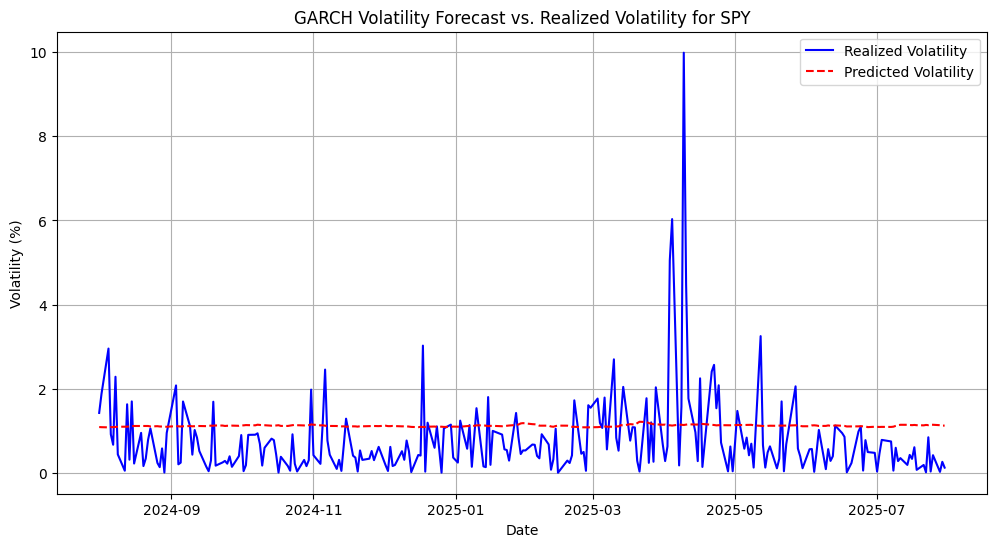

In [6]:
# Use the trained model to forecast the conditional variance for the test period
num_test_obs = len(test_returns)

# Forecast the conditional variance
forecasts = res_train.forecast(horizon=num_test_obs, method='simulation', reindex=False)

# Extract the predicted conditional variance
predicted_variance = forecasts.variance.dropna().iloc[0]

# Take the square root to get the predicted standard deviation (volatility)
predicted_volatility = np.sqrt(predicted_variance)

# Align the index of the predicted volatility with the index of the test data.
# This ensures that both series can be plotted on the same time-based x-axis.
predicted_volatility.index = test_returns.index

# Get the realized volatility from the test set
realized_volatility = np.abs(test_returns)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(realized_volatility, label='Realized Volatility', color='blue')
plt.plot(predicted_volatility, label='Predicted Volatility', color='red', linestyle='--')
plt.title(f'GARCH Volatility Forecast vs. Realized Volatility for {ticker}')
plt.ylabel('Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

--- Forecast Performance Metrics ---
Mean Squared Error (MSE): 1.008652
Mean Absolute Error (MAE): 0.670256
R-squared (R²): -0.020206


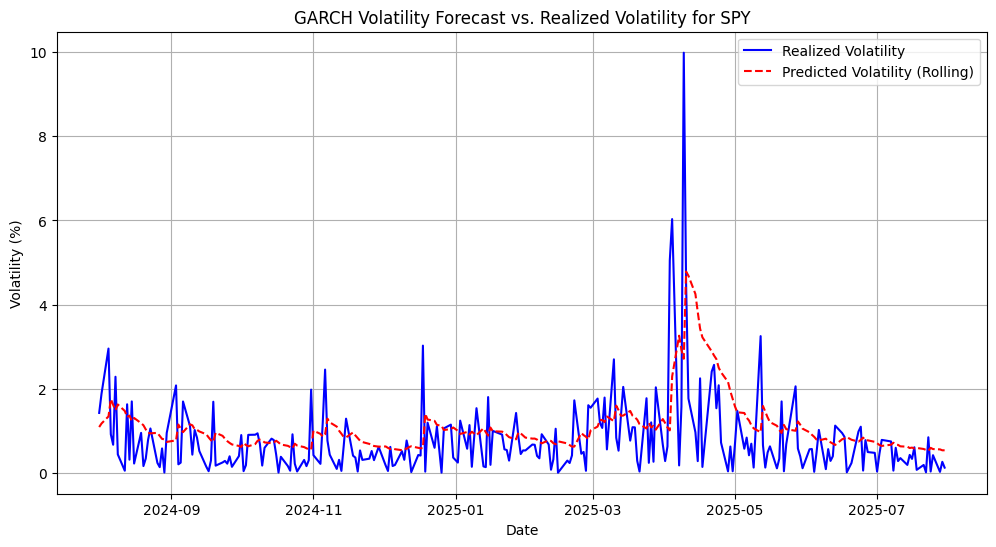

In [7]:
# --- Rolling Forecast Implementation ---

# Create a list to store the rolling one-day-ahead volatility forecasts
rolling_forecasts = []

# Loop through the test data, simulating a walk-forward process
for i in range(len(test_returns)):
    # Define the current training window
    # The training window grows by one observation in each iteration
    current_train_returns = returns[:len(train_returns) + i]

    # Fit the GARCH(1,1) model on the current training window
    am_rolling = arch_model(current_train_returns, vol='Garch', p=1, q=1, mean='Constant')
    res_rolling = am_rolling.fit(disp='off')

    # Use the model to forecast the conditional variance for the next day (horizon=1)
    one_day_forecast = res_rolling.forecast(horizon=1)

    # Extract the predicted conditional volatility for the next day
    predicted_vol = np.sqrt(one_day_forecast.variance.iloc[-1].values[0])

    # Append the forecast to our list
    rolling_forecasts.append(predicted_vol)


# --- Data Preparation for Plotting ---

# Convert the list of forecasts into a pandas Series
# We use the index from the test_returns to align the forecasts correctly
predicted_volatility_rolling = pd.Series(rolling_forecasts, index=test_returns.index)

# The realized volatility is simply the absolute value of the test returns
realized_volatility = np.abs(test_returns)

# --- Quantitative Analysis ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate the error metrics
mse = mean_squared_error(realized_volatility, predicted_volatility_rolling)
mae = mean_absolute_error(realized_volatility, predicted_volatility_rolling)
r2 = r2_score(realized_volatility, predicted_volatility_rolling)

print("--- Forecast Performance Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# --- Plotting the Results ---

# Plot the results using the same logic as before
plt.figure(figsize=(12, 6))
plt.plot(realized_volatility, label='Realized Volatility', color='blue')
plt.plot(predicted_volatility_rolling, label='Predicted Volatility (Rolling)', color='red', linestyle='--')
plt.title(f'GARCH Volatility Forecast vs. Realized Volatility for {ticker}')
plt.ylabel('Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()